# Homework 10

## Problem 1. 30 POINTS
Create a bash shell script that will create a sqlite database of the 4 csv files in this directory. Make sure that you assing meaningful data types and constraints to your database.

In [6]:
%%bash
#Review each CSV to get a sense of the data 

#Billing:
head -3 billing.csv
# 3 Variables: 
# billingid (INT) , encounterid (INT, FOREIGN KEY) , code (TEXT)

head -3 encounter.csv
# 6 Variables: 
# encounterid (INT + FOREIGN KEY), patientid (INT + PRIM KEY)
# encounterdate(NUMERIC), encounterphys (INT), encounterreason (TEXT), billingamount(REAL)

head -3 patient.csv
# 5 Variables: 
# patientid (INT + PRIM KEY), lastname(TEXT), firstname(TEXT), 
# gender (TEXT), dob (NUMERIC)

head -3 physician.csv
# 4 Variables: 
# physicianid (INT + FOREGIN KEY), lastname(TEXT)
# firstname(TEXT), speciality (TEXT)

﻿billingid,encounterid,code
1,1,54321
2,1,54322
﻿encounterid,patientid,encounterdate,encounterphysician,encounterreason,billingamount
1,1,3/6/63,1,checkup,99.32
2,3,5/4/82,4,cough,100.01
﻿patientid,lastname,firstname,gender,dob
1,doe,john,m,2/3/63
2,doe,jane,f,7/23/71
﻿physicianid,lastname,firstname,specialty
1,whitecoat,bill,pediatrics
2,satterwhite,jill,geriatrics


In [7]:
%%bash

#Create script file
touch patientscript.sh

#Use Heredoc to create tables
cat>patientscript.sh <<EOF

-- #Create schema tables based on the 4 csv files

CREATE TABLE billing (
billingid INTEGER PRIMARY KEY NOT NULL,
encounterid INTEGER,
code VARCHAR,
FOREIGN KEY (encounterid) REFERENCES encounter (encounterid)
);

CREATE TABLE encounter (
encounterid INTEGER PRIMARY KEY NOT NULL,
patientid INTEGER,
encounterdate DATE,
encounterphysician INTEGER,
encounterreason VARCHAR,
billingamount FLOAT,
FOREIGN KEY (patientid) REFERENCES patient (patientid),
FOREIGN KEY (encounterphysician) REFERENCES physician (physicianid)
);

CREATE TABLE patient (
patientid INTEGER PRIMARY KEY NOT NULL,
lastname VARCHAR,
firstname VARCHAR,
gender VARCHAR,
dob DATE
);

CREATE TABLE physician (
physicianid INTEGER PRIMARY KEY NOT NULL,
lastname VARCHAR,
firstname VARCHAR,
speciality VARCHAR
);

-- #Indicate mode and separator of data
.mode csv
.separator ","

-- #Import csv files into created tables
.import billing.csv billing
.import encounter.csv encounter
.import patient.csv patient
.import physician.csv physician

EOF


In [8]:
%%bash
#Execute script within database
sqlite3 patient.db
.read patientscript.sh

billing.csv:1: INSERT failed: datatype mismatch
encounter.csv:1: INSERT failed: datatype mismatch
patient.csv:1: INSERT failed: datatype mismatch
physician.csv:1: INSERT failed: datatype mismatch


In [9]:
%%bash
#Review insert errors - no problems seem to be appearing
sqlite3 patient.db
.separator ", "
SELECT * FROM patient;
SELECT * FROM encounter;
SELECT * FROM billing;
SELECT * FROM physician;

1, doe, john, m, 2/3/63
2, doe, jane, f, 7/23/71
3, sickly, joseph, m, 4/2/81
4, well, sally, f, 8/17/87
5, daily, bob, m, 9/2/91
1, 1, 3/6/63, 1, checkup, 99.32
2, 3, 5/4/82, 4, cough, 100.01
3, 3, 5/8/83, 4, checkup, 43.76
4, 3, 6/7/89, 3, flu, 553.23
5, 3, 7/1/89, 3, dyspnea, 93.21
6, 5, 10/5/98, 3, back pain, 54.23
7, 5, 11/9/99, 2, checkup, 321.46
8, 3, 10/21/92, 3, headache, 72.11
9, 1, 11/2/85, 2, fever, 87.65
10, 3, 11/15/93, 1, stomach ache, 25.78
1, 1, 54321
2, 1, 54322
3, 2, 78634
4, 3, 23847
5, 4, 78645
6, 5, 22211
7, 5, 30000
8, 5, 46352
9, 5, 45221
10, 6, 10001
11, 7, 42222
12, 8, 75533
13, 8, 23463
14, 9, 78654
15, 9, 30002
16, 9, 48373
17, 9, 25474
18, 9, 99987
19, 9, 47232
20, 10, E8763
1, whitecoat, bill, pediatrics
2, satterwhite, jill, geriatrics
3, na, li, cardiology
4, wei, liu, nephrology


## Problem 2. 30 POINTS.
Using python, answer the following questions:


In [1]:
import pandas as pd
from sqlalchemy import create_engine, inspect, MetaData, Table

#Create engine to connect to patient.db created in Problem 1
patientengine = create_engine('sqlite:///patient.db')
meta = MetaData()

#Import tables as Pandas DFs
billing = pd.read_sql_table('billing', patientengine)
physician = pd.read_sql_table('physician', patientengine)

#Issue coercing date type(in encounter and patient) to table; Convert CSV to Pandas DF
encounter = pd.read_csv('encounter.csv')
patient = pd.read_csv('patient.csv')

    1. Provide code that creates a pandas dataframe that contains a patient-level dataset with:
        - LastName
        - FirstName
        - Total Billing Amount

In [2]:
#Merge Patient and Encounter tables on 'patientID' to match billing amounts to patient information
patientbilling = pd.merge(patient, encounter, on='patientid', how='inner')

#Extract only columns of note
patientbilling = pd.DataFrame(patientbilling, columns=['lastname', 'firstname', 'billingamount'])

#Create new dataframe with sum of billing amount based on last name and first name; reset index
totalBilling = pd.DataFrame(patientbilling.groupby(['lastname', 'firstname'])['billingamount'].sum().reset_index())

#Change billing amount column name
totalBilling.rename(columns={"lastname":"LastName", "firstname":"FirstName", "billingamount": "TotalBillingAmount"}, inplace=True)

#Show new dataframe
totalBilling

,LastName,FirstName,TotalBillingAmount
0,daily,bob,375.69
1,doe,john,186.97
2,sickly,joseph,888.10


    2. The billing department needs to modify each billing statment so that we take the total billing amount for each person, multiply it by 4.2 and subtract 10. Create a new column on your pandas dataframe that applies this correction and name this variable `correction`.

In [3]:
#Create new column with transformation
totalBilling['Correction'] = (totalBilling.TotalBillingAmount * 4.2) - 10

#View updated dataframe
totalBilling

,LastName,FirstName,TotalBillingAmount,Correction
0,daily,bob,375.69,1567.898
1,doe,john,186.97,775.274
2,sickly,joseph,888.10,3720.020


    3. For all patients less than 40 years old, create a pandas data frame that contains:
        - LastName
        - FirstName
        - physician last name
        - physician first name
        - total times seen that physician

In [4]:
#Rename 'Encounterphysician' 'PhysicianID' for easier mapping
encounter.rename(columns={"encounterphysician": "physicianid"}, inplace=True)

#Merge Patient and Encounter on PatientID
patientEncounter = pd.merge(patient, encounter, on='patientid', how='inner')

#Merge patientEncounter and Physician on PhyisicianID
physPatEnc = pd.merge(patientEncounter, physician, on='physicianid', how='inner')

#Rename First/Last Names
physPatEnc.rename(columns={"lastname_x": "LastName", "firstname_x":"FirstName", "lastname_y": "Physician Last Name", "firstname_y":"Physician First Name"}, inplace=True)

#Create Age Variable
physPatEnc['dobyear'] = pd.DatetimeIndex(physPatEnc['dob']).year

#Adjust Incorrect Year
physPatEnc.dobyear.replace([2063], [1963], inplace=True)

#Filter Age > 40
physPatEnc = physPatEnc[(physPatEnc.dobyear > (2018-40))]

#Create count dataframe; reset index
visits = pd.DataFrame(physPatEnc.groupby(["LastName", "FirstName", "Physician Last Name", "Physician First Name"]).size().reset_index(name='count'))

#Rename last column
visits.rename(columns={"count": "Total Times Seen Physician"}, inplace=True)

#View final dataframe
visits

,LastName,FirstName,Physician Last Name,Physician First Name,Total Times Seen Physician
0,daily,bob,na,li,1
1,daily,bob,satterwhite,jill,1
2,sickly,joseph,na,li,3
3,sickly,joseph,wei,liu,2
4,sickly,joseph,whitecoat,bill,1


## Problem 1. 15 POINTS
You should have received an email that contains:
    - host
    - user
    - password
    
Go ahead and create three environment variables that hold this information. From this point forward, if you need this information, you should refer to the environment variables and NOT the values themselves. You will lose all points, if the values themselves are in the code and submitted to github. You will have effectively disclosed very sensitive data. **NOTE**, there is no code you turn in to get points for this problem. Rather, I will know that you have done this by reviewing the code below.

In [5]:
#Reference code below

#Avanis-MacBook:~ avanigupta$ cd bios821/JUPYTER/home_work/homework10
#Avanis-MacBook:~ avanigupta$ export host="*****"
#Avanis-MacBook:~ avanigupta$ export user="*****"
#Avanis-MacBook:~ avanigupta$ export password="*****"
#Avanis-MacBook:~ avanigupta$ jupyter notebook

## Problem 2. 5 POINTS
Create a `sqlalchemy` engine that is connected to our database. **NOTE** use the environment variables set up in problem 1 to do this. There should be NO host, username, or passwords visible if you are using environment variables correctly. You may receive some `ImportError`. You will need to figure out how to resolve these issues.

In [6]:
#Need to install psycopg2 to run Postgres DB:

#%%bash
#conda install -c anaconda psycopg2 

In [7]:
from sqlalchemy import create_engine
import os

#Create database string with environment variables
db = str("postgres://")+(os.getenv("user"))+str(':')+(os.getenv("password"))+str('@')+os.getenv("host")

#Create engine to connect to postgres DB
engine = create_engine(db)

## Problem 3. 20 POINTS
Using the engine created in Problem 2. Use sqlalchemy to help you create a hand drawn ER diagram. Please find a way to get you hand-drawn ER diagram into this repository. HINT, if you take a picture with your phone, you can use that image (which is just a file) to put into this directory.

In [8]:
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy import Table
import pprint

#Inspect engine to view tables & metadata information
inspector = inspect(engine)

#Get table information
print(inspector.get_table_names())

#Create a MetaData instance & reflect
metadata = MetaData()
metadata.reflect(bind=engine)

#Create for loop for easier schema view
for table in metadata.tables.values():
    print('*************************')
    print('TABLE: ' + table.name)
    p = str(table.primary_key)
    print(str('Primary Key:')+(p[28:50]))
    print(table.foreign_keys)
    print('COLUMNS:')
    for column in table.c:
        print(('\t' + column.name))
        print('\t\t' + str(column.type))

['patient', 'physician', 'encounter', 'billing']
*************************
TABLE: patient
Primary Key:'patientid', INTEGER()
set()
COLUMNS:
	patientid
		INTEGER
	lastname
		VARCHAR(50)
	firstname
		VARCHAR(50)
	gender
		VARCHAR(1)
	dob
		DATE
*************************
TABLE: physician
Primary Key:'physicianid', INTEGER
set()
COLUMNS:
	physicianid
		INTEGER
	lastname
		VARCHAR(50)
	firstname
		VARCHAR(50)
	specialty
		VARCHAR(50)
*************************
TABLE: encounter
Primary Key:'encounterid', INTEGER
{ForeignKey('physician.physicianid'), ForeignKey('patient.patientid')}
COLUMNS:
	encounterid
		INTEGER
	patientid
		INTEGER
	encounterdate
		DATE
	encounterphysician
		INTEGER
	encounterreason
		VARCHAR(50)
	billingamount
		DOUBLE PRECISION
*************************
TABLE: billing
Primary Key:'billingid', INTEGER()
{ForeignKey('encounter.encounterid')}
COLUMNS:
	billingid
		INTEGER
	encounterid
		INTEGER
	code
		VARCHAR(50)


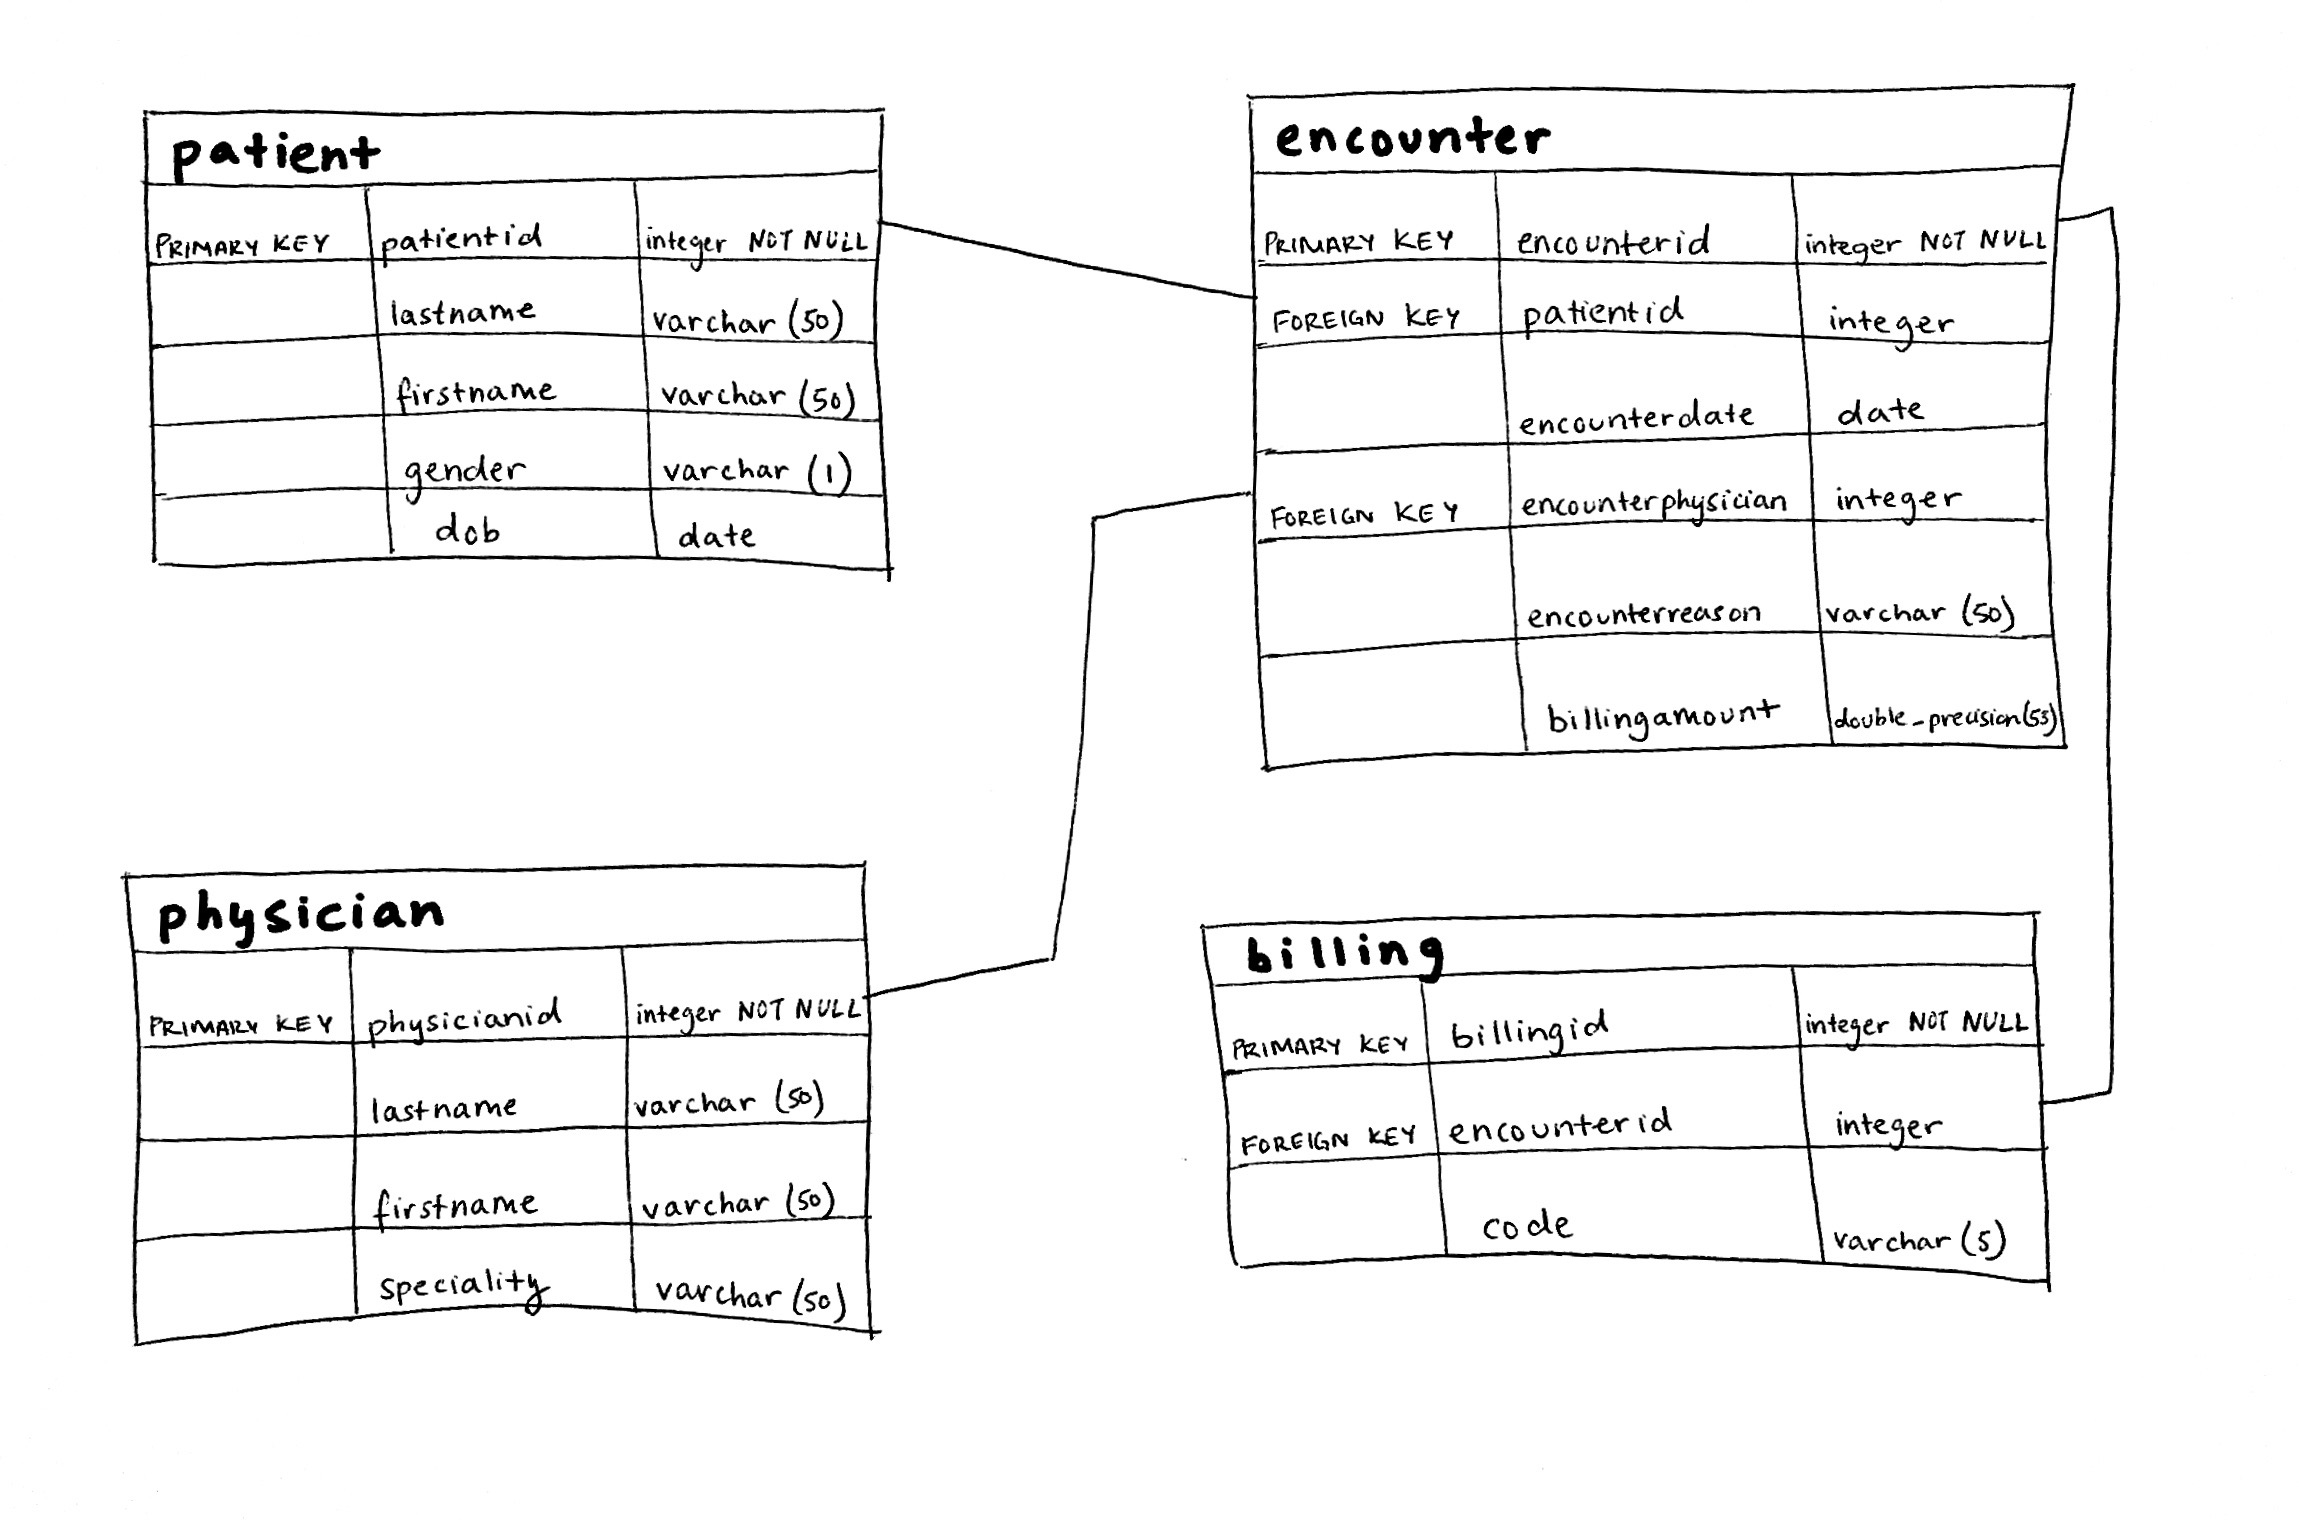

In [9]:
#Convert above schema to basic ER/schema diagram
#Import hand drawn ER/schema diagram 

from IPython.display import Image
Image(filename='ERdiagram.jpeg') 